<a href="https://colab.research.google.com/github/neohaky/deeplearning/blob/main/tugas3deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.preprocessing import image
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC


In [2]:
# Ganti dengan API milik kamu jika perlu
os.environ['KAGGLE_USERNAME'] = 'arcade21'
os.environ['KAGGLE_KEY'] = '979a17976cfa32f67b78e47aa89c3d32'

!kaggle datasets download -d arcade21/muhammad-zhaky-arkan
!unzip -q muhammad-zhaky-arkan.zip
!ls


Dataset URL: https://www.kaggle.com/datasets/arcade21/muhammad-zhaky-arkan
License(s): unknown
DatasetMultilabel_MuhammadZhakyArkan_202255202083
muhammad-zhaky-arkan.zip
sample_data
traindataset_Muhammad_Zhaky_Arkan_202255202083.csv


In [3]:
df = pd.read_csv('/content/traindataset_Muhammad_Zhaky_Arkan_202255202083.csv')

SIZE = 224
X_dataset = []
image_directory = '/content/DatasetMultilabel_MuhammadZhakyArkan_202255202083'

for i in tqdm(range(df.shape[0])):
    img_path = os.path.join(image_directory, df['id'][i] + '.jpg')
    img = image.load_img(img_path, target_size=(SIZE, SIZE, 3))
    img = image.img_to_array(img) / 255.
    X_dataset.append(img)

X = np.array(X_dataset)
y = np.array(df.drop(['id', 'objek'], axis=1))


100%|██████████| 314/314 [00:31<00:00, 10.03it/s]


In [4]:
# Validasi 50% supaya lebih menantang, tidak terlalu mudah
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=20)


In [5]:
base_model = MobileNetV2(input_shape=(SIZE, SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = True

# Fine-tune hanya bagian akhir saja
for layer in base_model.layers[:100]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,342,180 (8.93 MB)

 Trainable params: 1,945,636 (7.42 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [6]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - auc: 0.8379 - loss: 0.5269 - val_auc: 0.9631 - val_loss: 0.2459
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - auc: 0.9766 - loss: 0.2391 - val_auc: 0.9611 - val_loss: 0.2502
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - auc: 0.9773 - loss: 0.1982 - val_auc: 0.9501 - val_loss: 0.2952
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - auc: 0.9859 - loss: 0.1478 - val_auc: 0.9480 - val_loss: 0.3070
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - auc: 0.9957 - loss: 0.0687 - val_auc: 0.9709 - val_loss: 0.2189
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - auc: 0.9960 - loss: 0.0835 - val_auc: 0.9912 - val_loss: 0.1965
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - auc: 0.9986 - loss: 0.0473 - val_auc: 0.9944 - val_loss: 0.1858
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - auc: 0.9982 - loss: 0.0506 - val_auc: 0.9943 - val_loss: 0.2094
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - auc: 0.9998 - loss: 0.0311 - val_auc: 

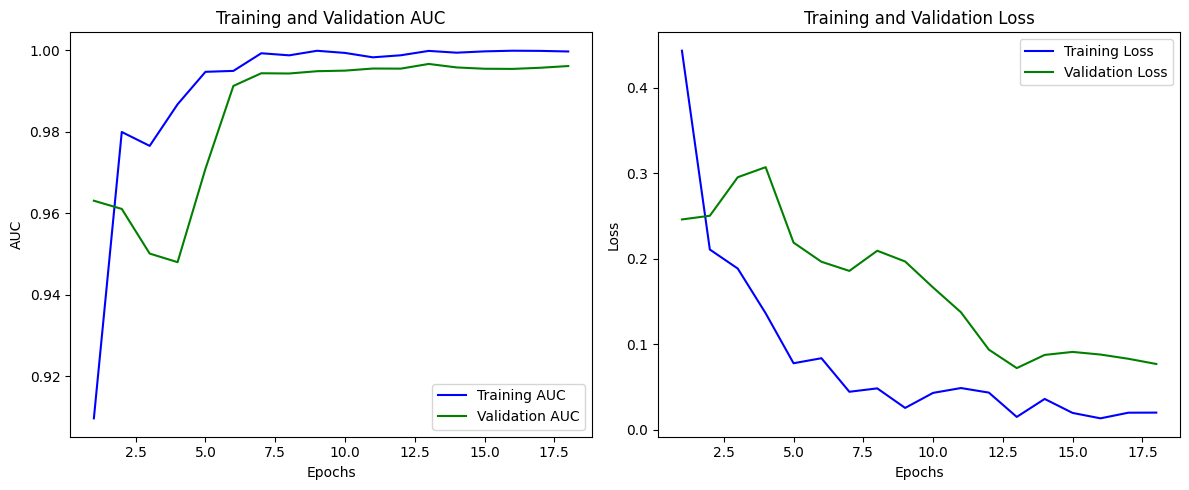

In [7]:
auc = history.history['auc']
val_auc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(auc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, auc, 'b', label='Training AUC')
plt.plot(epochs, val_auc, 'g', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs'); plt.ylabel('AUC'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - auc: 0.9963 - loss: 0.0833
AUC = 99.66%
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
              precision    recall  f1-score   support

 spatula kue       0.93      0.95      0.94       103
      piring       1.00      0.98      0.99        52
     gunting       1.00      1.00      1.00       157
 sendok nasi       1.00      1.00      1.00       157

   micro avg       0.99      0.99      0.99       469
   macro avg       0.98      0.98      0.98       469
weighted avg       0.99      0.99      0.99       469
 samples avg       0.99      0.99      0.98       469



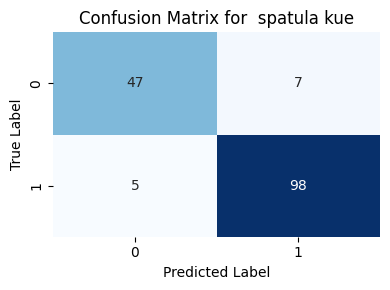

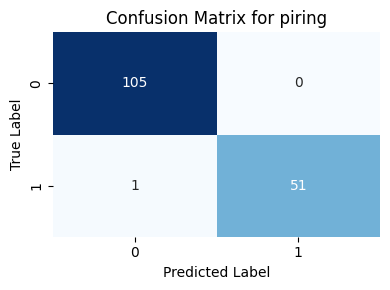

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


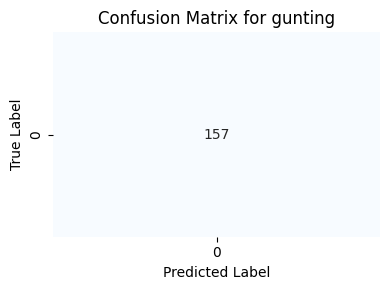

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


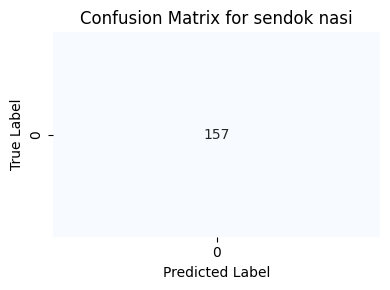

In [8]:
loss, auc = model.evaluate(X_test, y_test)
print("AUC = {:.2f}%".format(auc * 100))

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

classes = np.array(df.columns[2:])
print(classification_report(y_test, y_pred_classes, target_names=classes))

# Confusion matrix per class
for i in range(len(classes)):
    cm = confusion_matrix(y_test[:, i], y_pred_classes[:, i])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {classes[i]}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
sendok nasi: 1.000
gunting: 1.000
 spatula kue: 0.109
piring: 0.000


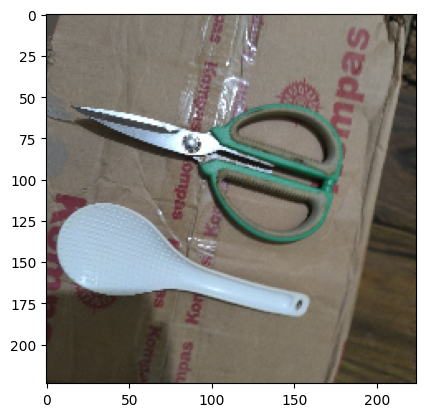

In [9]:
img_path = '/content/DatasetMultilabel_MuhammadZhakyArkan_202255202083/Gambar315.jpg'
img = image.load_img(img_path, target_size=(SIZE, SIZE, 3))
img = image.img_to_array(img) / 255.
plt.imshow(img / 1.0)
img = np.expand_dims(img, axis=0)

proba = model.predict(img)
sorted_idx = np.argsort(proba[0])[::-1]

for i in range(4):
    print(f"{classes[sorted_idx[i]]}: {proba[0][sorted_idx[i]]:.3f}")
